In [16]:
!wget http://cs301.pintoenterprisetech.com/GME.csv

--2021-11-17 19:56:25--  http://cs301.pintoenterprisetech.com/out.csv
Resolving cs301.pintoenterprisetech.com (cs301.pintoenterprisetech.com)... 157.245.119.43, 2604:a880:800:10::904:6001
Connecting to cs301.pintoenterprisetech.com (cs301.pintoenterprisetech.com)|157.245.119.43|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129534 (126K) [text/csv]
Saving to: ‘out.csv’

out.csv             100%[===================>] 126.50K   630KB/s    in 0.2s    

2021-11-17 19:56:26 (630 KB/s) - ‘out.csv’ saved [129534/129534]



In [10]:
import pandas as pd
import datetime

In [17]:
df = pd.read_csv("out.csv")

In [18]:
GMEdf = df.drop(['timekey', 'ticker'], axis=1).rename(columns={"timestamp" : "ds", "avg(sentiment)" : "avg(sentiment)"})

In [20]:
GMEdf.head()

,ds,avg(sentiment)
0,2021-10-31 02:48:20,0.020940
1,2021-10-31 02:51:21,0.339265
2,2021-10-31 03:03:52,0.375158
3,2021-10-31 03:10:07,0.181590
4,2021-10-31 03:20:05,-0.014369


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
GMEpricesDf = pd.read_csv('/content/drive/MyDrive/Data/GME.csv')
GMEpricesDf['Date'] = pd.to_datetime(GMEpricesDf['Date'])
GMEpricesDf.set_index('Date', inplace=True)
GMEpricesDf = GMEpricesDf.resample('D').pad()
def populate_target_prices(ds):
  date = datetime.datetime.strptime(ds, "%Y-%m-%d %H:%M:%S")
  date1 = date+datetime.timedelta(days=1)
  if date.hour < 16:
    try:
      return GMEpricesDf.loc[date.strftime("%Y-%m-%d")]['Close']
    except:
      pass
  else:
    try:
      return GMEpricesDf.loc[date1.strftime("%Y-%m-%d")]['Close']
    except:
      pass

In [24]:
GMEpricesDf

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-17,11.650000,11.920000,11.230000,11.630000,11.630000,6678200
2020-11-18,11.800000,12.040000,11.560000,11.570000,11.570000,3169200
2020-11-19,11.600000,12.790000,11.450000,12.460000,12.460000,11787600
2020-11-20,12.550000,13.460000,12.540000,12.710000,12.710000,8395400
2020-11-21,12.550000,13.460000,12.540000,12.710000,12.710000,8395400
...,...,...,...,...,...,...
2021-11-13,202.139999,205.360001,197.880005,202.100006,202.100006,926700
2021-11-14,202.139999,205.360001,197.880005,202.100006,202.100006,926700
2021-11-15,203.860001,211.500000,201.690002,209.139999,209.139999,1466400


In [25]:
GMEdf['test'] = GMEdf['ds'].apply(populate_target_prices)
GMEdf = GMEdf.ffill()

In [26]:
GMEdf

,ds,avg(sentiment),test
0,2021-10-31 02:48:20,0.020940,183.509995
1,2021-10-31 02:51:21,0.339265,183.509995
2,2021-10-31 03:03:52,0.375158,183.509995
3,2021-10-31 03:10:07,0.181590,183.509995
4,2021-10-31 03:20:05,-0.014369,183.509995
...,...,...,...
2547,2021-11-17 19:10:07,0.214530,210.850006
2548,2021-11-17 19:20:33,0.436962,210.850006
2549,2021-11-17 19:30:03,0.159207,210.850006
2550,2021-11-17 19:40:00,0.340296,210.850006


In [27]:
!pip install prophet

     |████████████████████████████████| 65 kB 3.6 MB/s 
     |████████████████████████████████| 49 kB 7.2 MB/s 
     |████████████████████████████████| 214 kB 18.7 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640560 sha256=96af9e5bce3afefec575f15fd51d03633f17af998c62c58681888b57e798605d
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [28]:
from prophet import Prophet

First get future sentiment values

In [29]:
sentiment_m = Prophet(changepoint_prior_scale=0.01, seasonality_prior_scale=.1, seasonality_mode='additive')
sentiment_m.fit(GMEdf[['ds', 'avg(sentiment)']].rename(columns={'ds':'ds', 'avg(sentiment)':'y'}))

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [30]:
sentiment_future = sentiment_m.make_future_dataframe(periods=100, freq='H')
sentiment_future.tail()
sentiment_forecast = sentiment_m.predict(sentiment_future)
sentiment_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2647,2021-11-21 19:50:05,0.292731,0.117671,0.448542
2648,2021-11-21 20:50:05,0.294051,0.131631,0.462395
2649,2021-11-21 21:50:05,0.294685,0.134188,0.456698
2650,2021-11-21 22:50:05,0.294079,0.138762,0.446006
2651,2021-11-21 23:50:05,0.293470,0.125646,0.453186


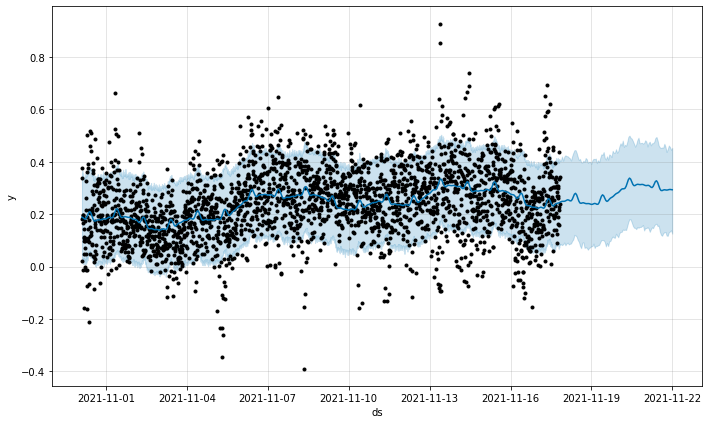

In [31]:
fig1 = sentiment_m.plot(sentiment_forecast)

In [32]:
sentiment_forecast.index = pd.to_datetime(sentiment_forecast.ds)

Add sentiment as additional regressor

In [33]:
m = Prophet(changepoint_prior_scale=0.005, seasonality_prior_scale=.1, seasonality_mode='additive')
m.add_regressor('avg(sentiment)', prior_scale=m.seasonality_prior_scale, standardize=True, mode='additive')
m.fit(GMEdf[['ds', 'test', 'avg(sentiment)']].rename(columns={'ds':'ds', 'test':'y'}))


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [34]:
def fillsentiment(ds):
  return sentiment_forecast.loc[pd.to_datetime(ds), 'yhat']

In [35]:
future = m.make_future_dataframe(periods=100, freq='H')
future['avg(sentiment)'] = future['ds'].apply(fillsentiment)
future.tail()

,ds,avg(sentiment)
2647,2021-11-21 19:50:05,0.292731
2648,2021-11-21 20:50:05,0.294051
2649,2021-11-21 21:50:05,0.294685
2650,2021-11-21 22:50:05,0.294079
2651,2021-11-21 23:50:05,0.293470


In [36]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2647,2021-11-21 19:50:05,216.210111,205.081892,226.505031
2648,2021-11-21 20:50:05,216.363034,205.100585,226.779413
2649,2021-11-21 21:50:05,216.589494,205.199518,226.845869
2650,2021-11-21 22:50:05,216.852411,205.040589,227.477445
2651,2021-11-21 23:50:05,217.068395,205.072880,228.146105


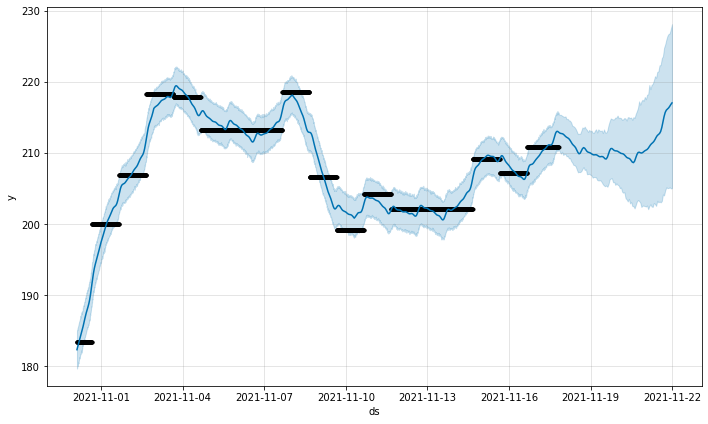

In [37]:
fig1 = m.plot(forecast)

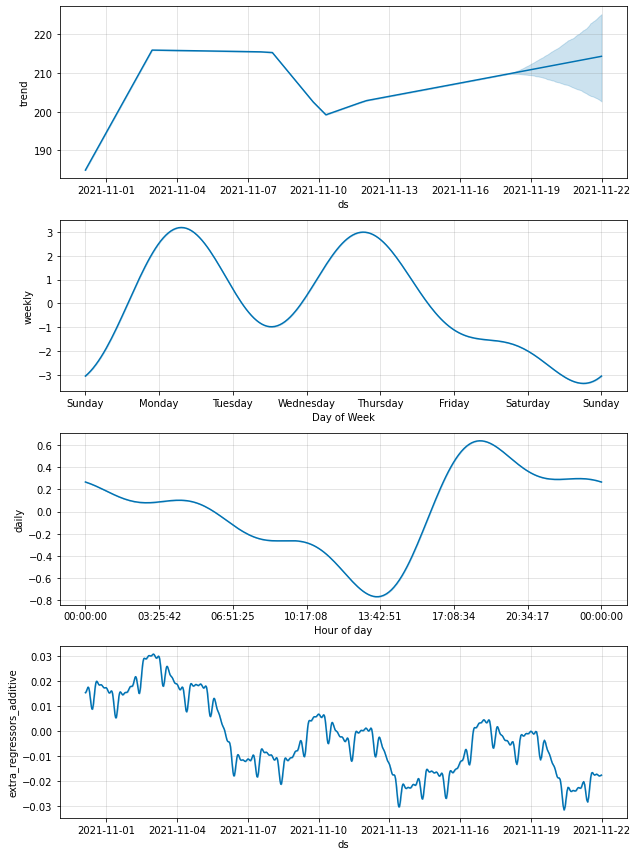

In [39]:
fig2 = m.plot_components(forecast)

In [40]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [41]:
plot_components_plotly(m, forecast)